# Rossman Store Sale - Prophet Model

In [ ]:
# https://facebook.github.io/prophet/docs/installation.html#python
    

In [ ]:
# ttps://facebook.github.io/prophet/docs/installation.html#python


In [ ]:
# dataset taken from
# https://www.kaggle.com/c/rossmann-store-sales/overview


# Reading the dataset

In [139]:
# calling all libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import datetime
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation, performance_metrics
from fbprophet.plot import plot_cross_validation_metric

In [2]:
# ignore harmless warnings
import warnings
warnings.filterwarnings('ignore')

In [12]:
# reading train dataset datasets

# sales_train = pd.read_csv('../Data Science for Business Package/3. Sales Department Data/train.csv')
df = pd.read_csv('train.csv')

In [13]:
print(df.info())
df.head()
# observations
# almost 1 million transactions with 8 columnsß

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Date           1017209 non-null  object
 3   Sales          1017209 non-null  int64 
 4   Customers      1017209 non-null  int64 
 5   Open           1017209 non-null  int64 
 6   Promo          1017209 non-null  int64 
 7   StateHoliday   1017209 non-null  object
 8   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 69.8+ MB
None


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


# Data preparation

In [14]:
# !pip install fbprophet

In [15]:
# checking the biggest store 

biggest_stores = df['Store'].value_counts(ascending = False)
biggest_stores


1023    942
666     942
675     942
163     942
674     942
       ... 
900     758
902     758
903     758
904     758
512     758
Name: Store, Length: 1115, dtype: int64

In [16]:
# let's search only for store = 85
df = df[df['Store'] == 85]
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 942 entries, 84 to 1016179
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Store          942 non-null    int64 
 1   DayOfWeek      942 non-null    int64 
 2   Date           942 non-null    object
 3   Sales          942 non-null    int64 
 4   Customers      942 non-null    int64 
 5   Open           942 non-null    int64 
 6   Promo          942 non-null    int64 
 7   StateHoliday   942 non-null    object
 8   SchoolHoliday  942 non-null    int64 
dtypes: int64(7), object(2)
memory usage: 73.6+ KB
None


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
84,85,5,2015-07-31,7791,971,1,1,0,1
1199,85,4,2015-07-30,7187,1000,1,1,0,1
2314,85,3,2015-07-29,7719,889,1,1,0,1
3429,85,2,2015-07-28,7533,920,1,1,0,1
4544,85,1,2015-07-27,7788,956,1,1,0,1


In [96]:
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values(by = 'Date', ascending = True, inplace = True)
df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
1016179,85,2,2013-01-01,4220,619,1,0,a,1
1015064,85,3,2013-01-02,6069,914,1,0,0,1
1013949,85,4,2013-01-03,5246,820,1,0,0,1
1012834,85,5,2013-01-04,5339,805,1,0,0,1
1011719,85,6,2013-01-05,5774,772,1,0,0,0


In [97]:
# checking for weekly
# print(len(df))
# df = df.resample(rule = 'W').sum()
# # df.index.freq = 'W'
# print(len(df))

In [98]:
df.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday'],
      dtype='object')

In [99]:
df_prophet = df[['Date', 'Sales']].copy()
df_prophet.columns = ['ds', 'y']
df_prophet

,ds,y
1016179,2013-01-01,4220
1015064,2013-01-02,6069
1013949,2013-01-03,5246
1012834,2013-01-04,5339
1011719,2013-01-05,5774
...,...,...
4544,2015-07-27,7788
3429,2015-07-28,7533
2314,2015-07-29,7719
1199,2015-07-30,7187


In [100]:
df_prophet.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 942 entries, 1016179 to 84
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      942 non-null    datetime64[ns]
 1   y       942 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 22.1 KB


In [101]:
# split the data into train and test
train = df_prophet.iloc[:-90]
test = df_prophet.iloc[-90:]
print(len(df_prophet), len(train), len(test))

942 852 90


In [121]:
df_prophet.tail()

,ds,y
4544,2015-07-27,7788
3429,2015-07-28,7533
2314,2015-07-29,7719
1199,2015-07-30,7187
84,2015-07-31,7791


# Prophet Model

In [103]:
# create and fit model

m = Prophet()
m.fit(train)



INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


# Forecasting

In [104]:
# forecast for 90 days
future = m.make_future_dataframe(periods = 90, freq = 'D')

In [105]:
future

,ds
0,2013-01-01
1,2013-01-02
2,2013-01-03
3,2013-01-04
4,2013-01-05
...,...
937,2015-07-27
938,2015-07-28
939,2015-07-29
940,2015-07-30


In [122]:
# forecast the future

forecast = m.predict(future)


In [123]:
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2013-01-01,7204.621399,4575.191501,8169.860324,7204.621399,7204.621399,-801.291842,-801.291842,-801.291842,-721.932267,-721.932267,-721.932267,-79.359575,-79.359575,-79.359575,0.0,0.0,0.0,6403.329557
1,2013-01-02,7204.379829,4544.113695,8004.622316,7204.379829,7204.379829,-930.800198,-930.800198,-930.800198,-808.785550,-808.785550,-808.785550,-122.014648,-122.014648,-122.014648,0.0,0.0,0.0,6273.579631
2,2013-01-03,7204.138260,4612.562896,8103.074389,7204.138260,7204.138260,-877.207572,-877.207572,-877.207572,-713.931498,-713.931498,-713.931498,-163.276073,-163.276073,-163.276073,0.0,0.0,0.0,6326.930688
3,2013-01-04,7203.896690,4867.873153,8484.090686,7203.896690,7203.896690,-654.671292,-654.671292,-654.671292,-451.701354,-451.701354,-451.701354,-202.969939,-202.969939,-202.969939,0.0,0.0,0.0,6549.225398
4,2013-01-05,7203.655121,3582.572763,7140.091538,7203.655121,7203.655121,-1917.035281,-1917.035281,-1917.035281,-1676.096836,-1676.096836,-1676.096836,-240.938445,-240.938445,-240.938445,0.0,0.0,0.0,5286.619840


In [124]:
forecast.head(3)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2013-01-01,7204.621399,4575.191501,8169.860324,7204.621399,7204.621399,-801.291842,-801.291842,-801.291842,-721.932267,-721.932267,-721.932267,-79.359575,-79.359575,-79.359575,0.0,0.0,0.0,6403.329557
1,2013-01-02,7204.379829,4544.113695,8004.622316,7204.379829,7204.379829,-930.800198,-930.800198,-930.800198,-808.785550,-808.785550,-808.785550,-122.014648,-122.014648,-122.014648,0.0,0.0,0.0,6273.579631
2,2013-01-03,7204.138260,4612.562896,8103.074389,7204.138260,7204.138260,-877.207572,-877.207572,-877.207572,-713.931498,-713.931498,-713.931498,-163.276073,-163.276073,-163.276073,0.0,0.0,0.0,6326.930688


In [125]:
forecast.tail(3)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
939,2015-07-29,7787.528458,4938.342919,8385.723302,7779.706812,7795.771180,-1047.914972,-1047.914972,-1047.914972,-808.785550,-808.785550,-808.785550,-239.129421,-239.129421,-239.129421,0.0,0.0,0.0,6739.613486
940,2015-07-30,7788.839021,5097.895803,8572.595696,7780.939056,7797.293692,-950.617809,-950.617809,-950.617809,-713.931498,-713.931498,-713.931498,-236.686311,-236.686311,-236.686311,0.0,0.0,0.0,6838.221212
941,2015-07-31,7790.149585,5318.932732,8743.679710,7782.171301,7798.813463,-682.932792,-682.932792,-682.932792,-451.701354,-451.701354,-451.701354,-231.231438,-231.231438,-231.231438,0.0,0.0,0.0,7107.216793


In [126]:
forecast.columns

Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'weekly', 'weekly_lower', 'weekly_upper', 'yearly', 'yearly_lower',
       'yearly_upper', 'multiplicative_terms', 'multiplicative_terms_lower',
       'multiplicative_terms_upper', 'yhat'],
      dtype='object')

In [127]:
forecast[['ds','yhat_lower', 'yhat_upper','yhat']].tail()

,ds,yhat_lower,yhat_upper,yhat
937,2015-07-27,6179.470713,9707.997893,7886.971393
938,2015-07-28,5018.831159,8560.220991,6825.607843
939,2015-07-29,4938.342919,8385.723302,6739.613486
940,2015-07-30,5097.895803,8572.595696,6838.221212
941,2015-07-31,5318.932732,8743.679710,7107.216793


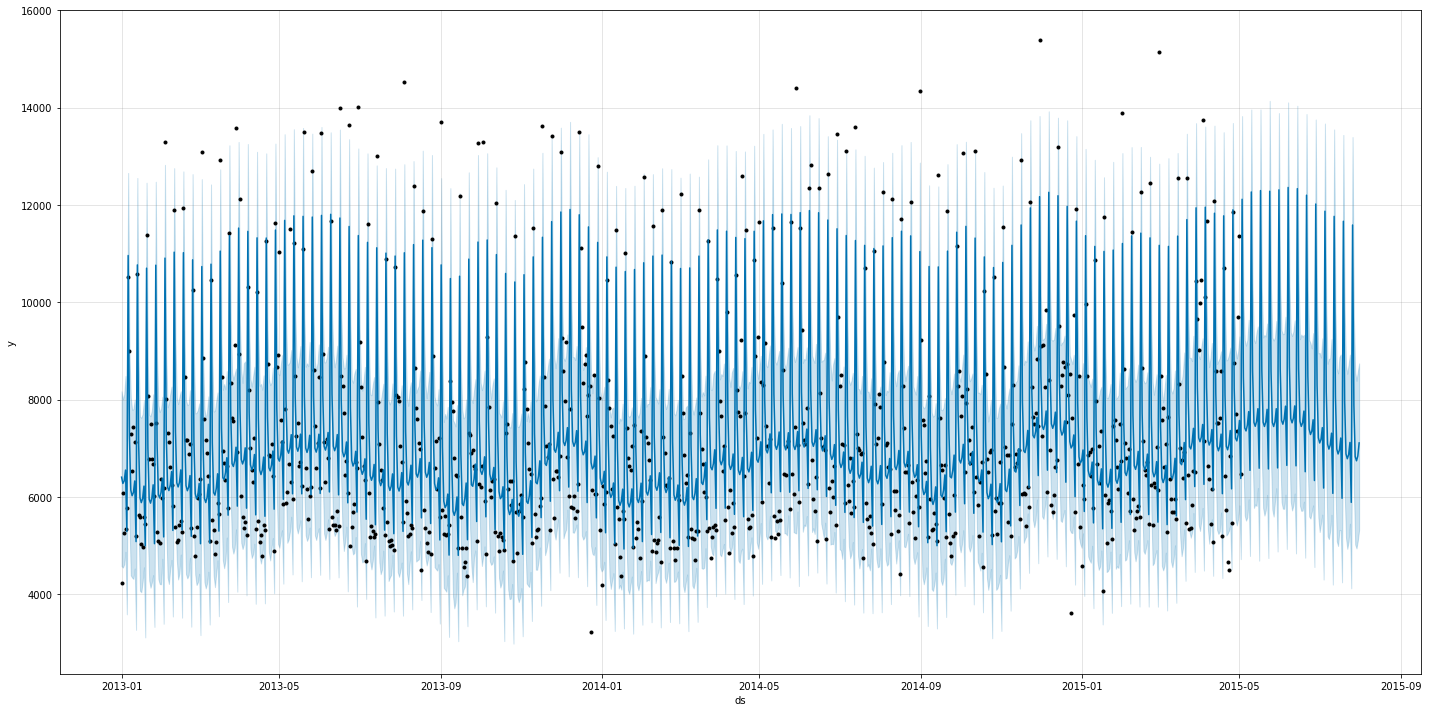

In [128]:
# plotting forecast

m.plot(forecast, figsize = (20,10)); # prophet's built-in tool


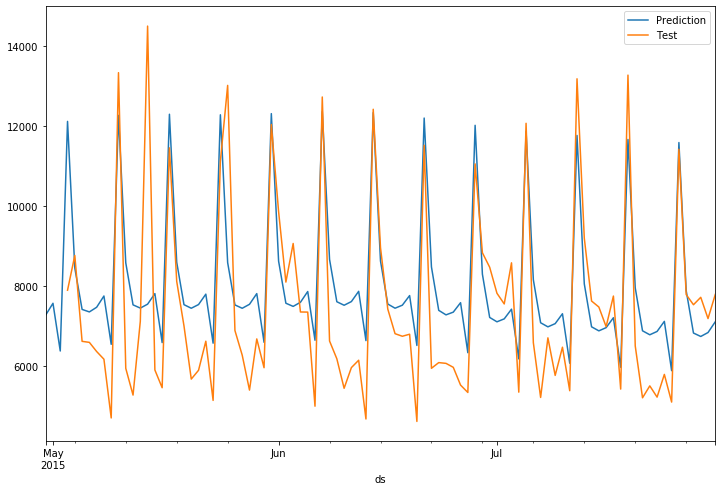

In [133]:
ax = forecast.plot(x = 'ds', y= 'yhat', label = 'Prediction', legend = True, figsize = (12,8))
test.plot( x ='ds', y='y',ax = ax, label = 'Test', legend=True, xlim=('2015-04-30', '2015-07-31'));

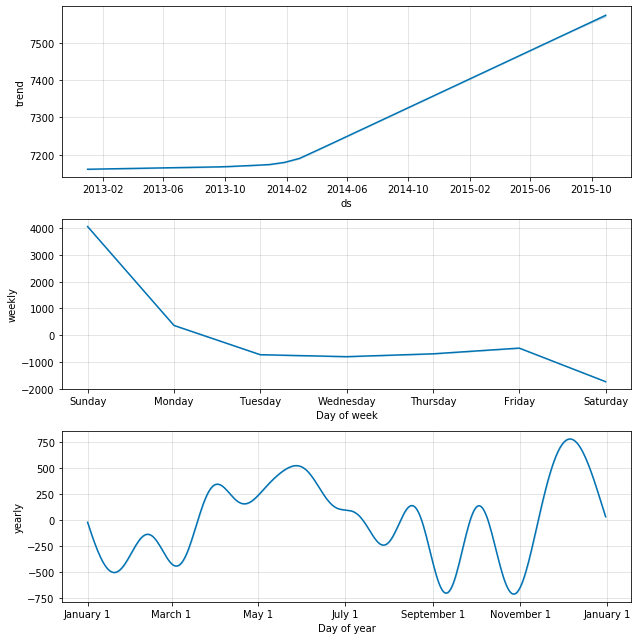

In [72]:
m.plot_components(forecast);

# Prophet Diagnosis

In [140]:
# Tutorial from here
# https://facebook.github.io/prophet/docs/diagnostics.html


df_cv = cross_validation(m, initial = 5*365, period = str(5*365)+' days', horizon = str(365)+ ' days')


INFO:fbprophet:Making 1 forecasts with cutoffs between 2014-05-02 00:00:00 and 2014-05-02 00:00:00


In [142]:
df_cv.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2014-05-03,6363.803548,4605.318394,8203.016670,5885,2014-05-02
1,2014-05-04,12052.541630,10130.264816,14015.768804,8298,2014-05-02
2,2014-05-05,8383.979518,6750.895911,10242.294269,9165,2014-05-02
3,2014-05-06,7351.271928,5594.050490,9151.787550,7453,2014-05-02
4,2014-05-07,7361.907058,5595.834188,8988.902246,7044,2014-05-02


In [143]:
df_cv.shape

(365, 6)

In [145]:
performance_metrics(df_cv)

,horizon,mse,rmse,mae,mape,mdape,coverage
0,36 days,3.180462e+06,1783.385120,1127.598723,0.154807,0.094339,0.805556
1,37 days,3.196667e+06,1787.922620,1139.339117,0.154575,0.094339,0.805556
2,38 days,3.520863e+06,1876.396406,1176.051408,0.153010,0.094339,0.805556
3,39 days,3.504054e+06,1871.911776,1156.289099,0.150929,0.093992,0.805556
4,40 days,3.517683e+06,1875.548753,1173.124965,0.153851,0.106898,0.805556
...,...,...,...,...,...,...,...
325,361 days,3.927104e+06,1981.692311,1383.876562,0.168408,0.141425,0.750000
326,362 days,3.902487e+06,1975.471336,1367.857800,0.164718,0.133020,0.750000
327,363 days,4.071049e+06,2017.684129,1413.188474,0.166962,0.133020,0.722222
328,364 days,4.561966e+06,2135.875927,1512.884380,0.174192,0.141425,0.694444


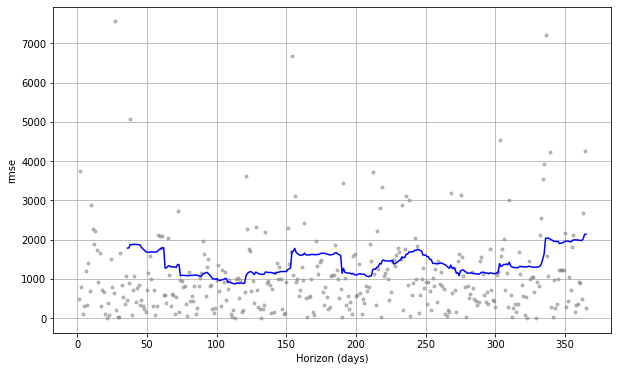

In [149]:
# plot rmse
plot_cross_validation_metric(df_cv, metric = 'rmse');
